In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

TICKER = "MSFT"
START  = "2000-01-01"
END    = "2010-01-01"

df = yf.download(TICKER, start=START, end=END)

window_size = 5
k = window_size

df['r']   = np.log(df['Close']).diff()

df['m']   = df['Close'].pct_change(k)
df['sma'] = df['Close']['MSFT'].rolling(k).mean()
df['d']   = df['Close']['MSFT'] - df['sma']
df['v']   = df['r'].rolling(k).std()
df['vol_ma'] = df['Volume']['MSFT'].rolling(k).mean()
df['u']      = df['Volume']['MSFT'] / df['vol_ma']
df.dropna(inplace=True)

def make_windows(df, window_size):
    X, Y = [], []
    for i in range(len(df) - window_size):
        block = df.iloc[i : i + window_size]
        X.append(block[['Close','r','m','d','v','u']].values)
        Y.append(df['Close'].iloc[i + window_size])
    X = np.stack(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)
    return X, Y

X, Y = make_windows(df, window_size)

N = len(X)
train_idx = int(0.7 * N)
val_idx   = int(0.85 * N)

X_train, Y_train = X[:train_idx], Y[:train_idx]
X_val,   Y_val   = X[train_idx:val_idx], Y[train_idx:val_idx]
X_test,  Y_test  = X[val_idx:], Y[val_idx:]

_, seq_len, n_feats = X_train.shape
X_train_flat = X_train.reshape(-1, n_feats)

scaler_X = StandardScaler()
scaler_X.fit(X_train_flat)


def scale_X(X):
    flat = X.reshape(-1, n_feats)
    return scaler_X.transform(flat).reshape(X.shape)

X_train_s = scale_X(X_train)
X_val_s   = scale_X(X_val)
X_test_s  = scale_X(X_test)

Y_train_col = Y_train.reshape(-1, 1)
scaler_y = StandardScaler()
scaler_y.fit(Y_train_col)

Y_train_s = scaler_y.transform(Y_train_col).ravel()
Y_val_s   = scaler_y.transform(Y_val.reshape(-1,1)).ravel()
Y_test_s  = scaler_y.transform(Y_test.reshape(-1,1)).ravel()

X_train, X_val, X_test = X_train_s, X_val_s, X_test_s
Y_train, Y_val, Y_test = Y_train_s, Y_val_s, Y_test_s

batch_size = 32

train_ds = TensorDataset(torch.from_numpy(X_train),
                         torch.from_numpy(Y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),
                         torch.from_numpy(Y_val))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)



[*********************100%***********************]  1 of 1 completed


Epoch  1 | Train: 0.5811 | Val: 0.0695
Epoch  2 | Train: 0.0568 | Val: 0.0396
Epoch  3 | Train: 0.0342 | Val: 0.0318
Epoch  4 | Train: 0.0273 | Val: 0.0172
Epoch  5 | Train: 0.0238 | Val: 0.0188
Epoch  6 | Train: 0.0227 | Val: 0.0166
Epoch  7 | Train: 0.0209 | Val: 0.0146
Epoch  8 | Train: 0.0208 | Val: 0.0199
Epoch  9 | Train: 0.0217 | Val: 0.0163
Epoch 10 | Train: 0.0202 | Val: 0.0186
Epoch 11 | Train: 0.0198 | Val: 0.0202
Epoch 12 | Train: 0.0200 | Val: 0.0142
Epoch 13 | Train: 0.0198 | Val: 0.0150
Epoch 14 | Train: 0.0204 | Val: 0.0188
Epoch 15 | Train: 0.0196 | Val: 0.0142
Epoch 16 | Train: 0.0199 | Val: 0.0145
Epoch 17 | Train: 0.0187 | Val: 0.0165
Epoch 18 | Train: 0.0205 | Val: 0.0183
Epoch 19 | Train: 0.0189 | Val: 0.0155
Epoch 20 | Train: 0.0187 | Val: 0.0182
Epoch 21 | Train: 0.0183 | Val: 0.0304
Epoch 22 | Train: 0.0194 | Val: 0.0297
Epoch 23 | Train: 0.0189 | Val: 0.0178
Epoch 24 | Train: 0.0183 | Val: 0.0241
Epoch 25 | Train: 0.0181 | Val: 0.0161
Epoch 26 | Train: 0.0185 

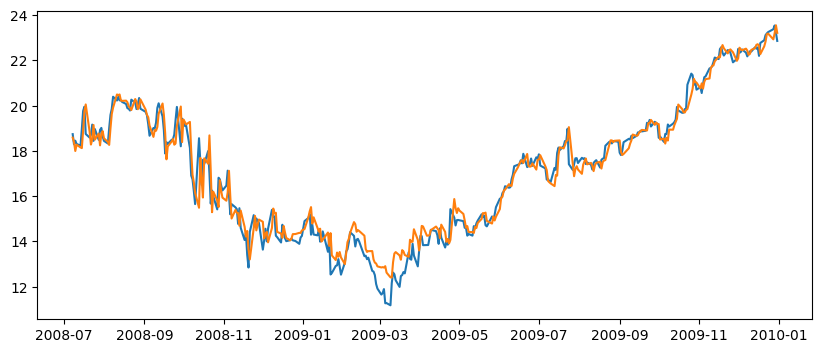

In [17]:
import torch.nn as nn
import torch.optim as optim

class StockLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last).squeeze(-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = StockLSTM(input_size=6, hidden_size=64).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
num_epochs = 50

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:2d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")


def collect_preds(loader):
    """Run the model on all batches in `loader` and return
       two flat Python lists of floats: (predictions, ground_truth)."""
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            out = out.view(-1).cpu().numpy()
            true = yb.view(-1).cpu().numpy()
            preds.extend(out.tolist())
            trues.extend(true.tolist())
    return preds, trues


train_preds, train_trues = collect_preds(train_loader)
val_preds,   val_trues   = collect_preds(val_loader)

test_ds     = TensorDataset(torch.from_numpy(X_test),
                            torch.from_numpy(Y_test))
test_loader = DataLoader(test_ds, batch_size=batch_size)
test_preds, test_trues = collect_preds(test_loader)

tp_s = np.array(test_preds)
tt_s = np.array(test_trues)

tp = scaler_y.inverse_transform(tp_s.reshape(-1,1)).ravel()
tt = scaler_y.inverse_transform(tt_s.reshape(-1,1)).ravel()

test_mse = np.mean((tp - tt)**2)
print(f"\nTest MSE (unscaled dollars): {test_mse:.4f}")

plt.figure(figsize=(10,4))
plt.plot(test_dates, tt, label="True Close")
plt.plot(test_dates, tp, label="Predicted Close")


for name, P, T in [
    ("TRAIN", train_preds, train_trues),
    ("VALID", val_preds,   val_trues),
    ("TEST",  test_preds,  test_trues),
]:
    print(f"\nFirst 10 {name} predictions vs true:")
    for p, t in zip(P[:10], T[:10]):
        print(f"  pred={p:8.2f}   true={t:8.2f}")


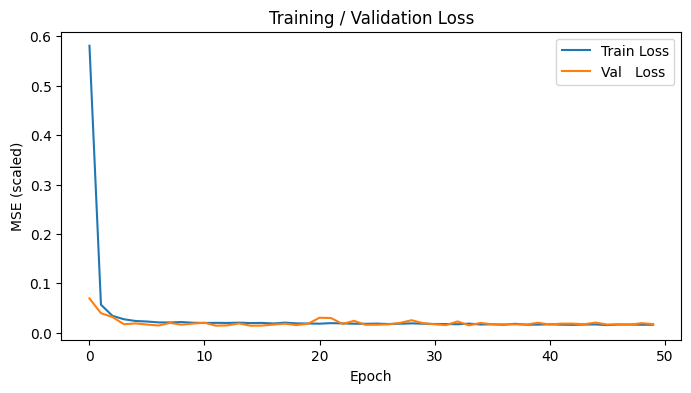

Test RMSE (unscaled dollars): 0.5594


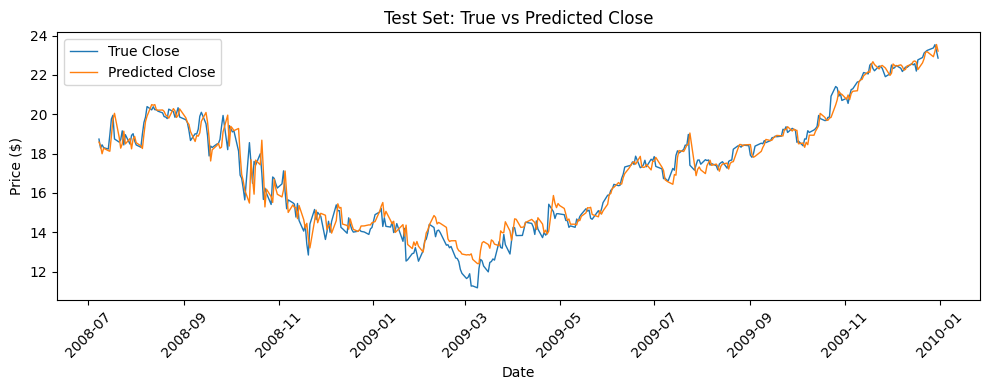

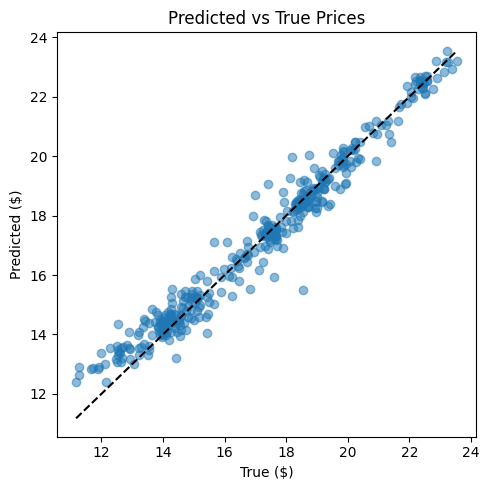

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val   Loss")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled)")
plt.legend()
plt.show()

test_rmse = np.sqrt(test_mse)
print(f"Test RMSE (unscaled dollars): {test_rmse:.4f}")

plt.figure(figsize=(10,4))
plt.plot(test_dates, tt, label="True Close", linewidth=1)
plt.plot(test_dates, tp, label="Predicted Close", linewidth=1)
plt.xticks(rotation=45)
plt.title("Test Set: True vs Predicted Close")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(tt, tp, alpha=0.5)
mn, mx = tt.min(), tt.max()
plt.plot([mn,mx],[mn,mx],"k--")
plt.title("Predicted vs True Prices")
plt.xlabel("True ($)")
plt.ylabel("Predicted ($)")
plt.tight_layout()
plt.show()

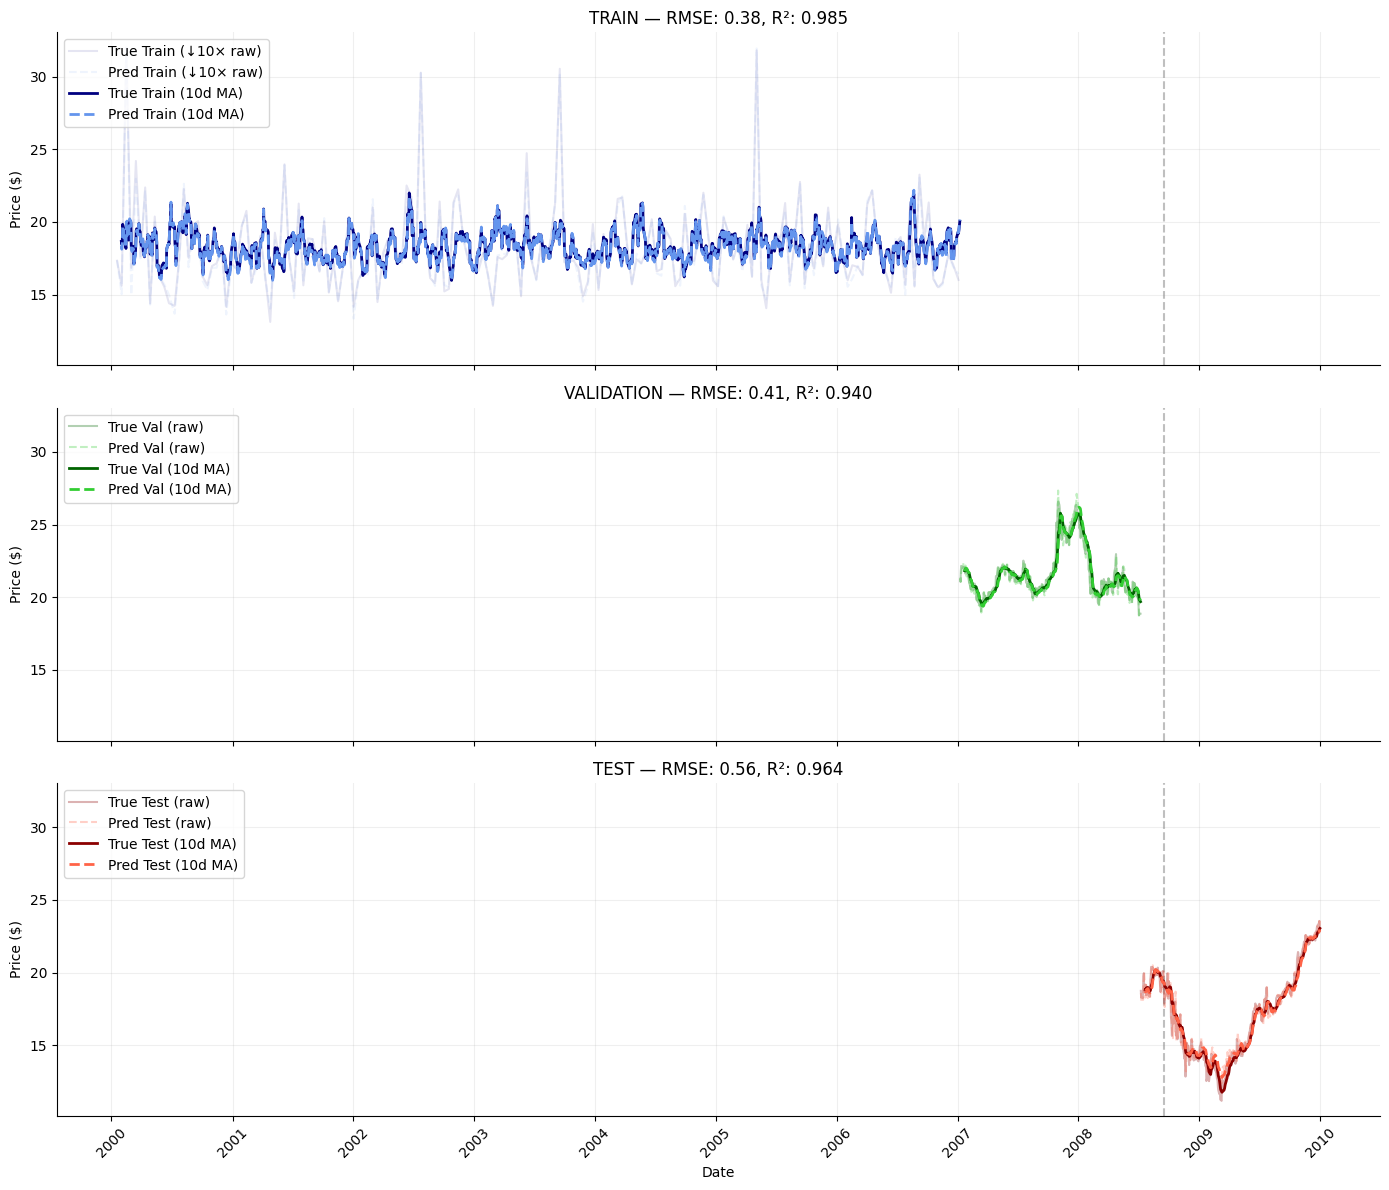

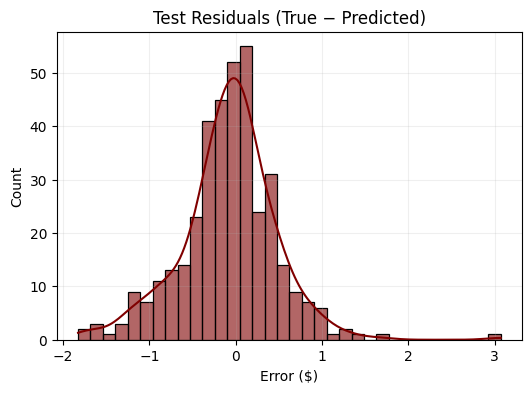

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score


all_dates   = df.index[window_size:]
train_dates = all_dates[:train_idx]
val_dates   = all_dates[train_idx:val_idx]
test_dates  = all_dates[val_idx:]


tp_train = np.array(train_preds_u)
tt_train = np.array(train_trues_u)
tp_val   = np.array(val_preds_u)
tt_val   = np.array(val_trues_u)
tp_test  = np.array(test_preds_u)
tt_test  = np.array(test_trues_u)


def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rmse_tr, r2_tr = compute_metrics(tt_train, tp_train)
rmse_va, r2_va = compute_metrics(tt_val,   tp_val)
rmse_te, r2_te = compute_metrics(tt_test,  tp_test)


window_smooth = 10
smooth = lambda arr, dates: pd.Series(arr, index=dates).rolling(window_smooth).mean()

tt_train_sm = smooth(tt_train, train_dates)
tp_train_sm = smooth(tp_train, train_dates)
tt_val_sm   = smooth(tt_val,   val_dates)
tp_val_sm   = smooth(tp_val,   val_dates)
tt_test_sm  = smooth(tt_test,  test_dates)
tp_test_sm  = smooth(tp_test,  test_dates)


ds = 10
train_dates_ds = train_dates[::ds]
tt_train_ds    = tt_train[::ds]
tp_train_ds    = tp_train[::ds]


fig, axes = plt.subplots(3, 1,
                         figsize=(14, 12),
                         sharex=True, sharey=True)


for ax in axes:
    ax.grid(alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


for ax in axes:
    ax.axvline(pd.to_datetime('2008-09-15'),
               color='gray', linestyle='--', alpha=0.5)


ax = axes[0]
ax.plot(train_dates_ds, tt_train_ds,
        color='navy', alpha=0.1, label='True Train (↓10× raw)')
ax.plot(train_dates_ds, tp_train_ds,
        color='cornflowerblue', linestyle='--', alpha=0.1, label='Pred Train (↓10× raw)')
ax.plot(train_dates, tt_train_sm,
        color='navy', linewidth=2, label=f'True Train ({window_smooth}d MA)')
ax.plot(train_dates, tp_train_sm,
        color='cornflowerblue', linestyle='--', linewidth=2, label=f'Pred Train ({window_smooth}d MA)')
ax.set_title(f"TRAIN — RMSE: {rmse_tr:.2f}, R²: {r2_tr:.3f}")
ax.set_ylabel("Price ($)")
ax.legend(loc='upper left')


ax = axes[1]
ax.plot(val_dates, tt_val,
        color='darkgreen', alpha=0.3, label='True Val (raw)')
ax.plot(val_dates, tp_val,
        color='limegreen', linestyle='--', alpha=0.3, label='Pred Val (raw)')
ax.plot(val_dates, tt_val_sm,
        color='darkgreen', linewidth=2, label=f'True Val ({window_smooth}d MA)')
ax.plot(val_dates, tp_val_sm,
        color='limegreen', linestyle='--', linewidth=2, label=f'Pred Val ({window_smooth}d MA)')
ax.set_title(f"VALIDATION — RMSE: {rmse_va:.2f}, R²: {r2_va:.3f}")
ax.set_ylabel("Price ($)")
ax.legend(loc='upper left')


ax = axes[2]
ax.plot(test_dates, tt_test,
        color='darkred', alpha=0.3, label='True Test (raw)')
ax.plot(test_dates, tp_test,
        color='tomato', linestyle='--', alpha=0.3, label='Pred Test (raw)')
ax.plot(test_dates, tt_test_sm,
        color='darkred', linewidth=2, label=f'True Test ({window_smooth}d MA)')
ax.plot(test_dates, tp_test_sm,
        color='tomato', linestyle='--', linewidth=2, label=f'Pred Test ({window_smooth}d MA)')
ax.set_title(f"TEST — RMSE: {rmse_te:.2f}, R²: {r2_te:.3f}")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


res = tt_test - tp_test
plt.figure(figsize=(6,4))
sns.histplot(res, kde=True, color='maroon', alpha=0.6)
plt.title("Test Residuals (True − Predicted)")
plt.xlabel("Error ($)")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

In [27]:
def summarize(y_true, y_pred, name):
    mse  = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:10s}  |  MSE: {mse:8.4f}  |  RMSE: {rmse:8.4f}  |  R²: {r2:6.4f}")


print("\n===== PERFORMANCE SUMMARY =====")
summarize(tt_train, tp_train, "TRAIN")
summarize(tt_val,   tp_val,   "VALID")
summarize(tt_test,  tp_test,  "TEST")


===== PERFORMANCE SUMMARY =====
TRAIN       |  MSE:   0.1439  |  RMSE:   0.3794  |  R²: 0.9848
VALID       |  MSE:   0.1650  |  RMSE:   0.4062  |  R²: 0.9398
TEST        |  MSE:   0.3129  |  RMSE:   0.5594  |  R²: 0.9643
